# Imports 

In [1]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('max_columns',1000)

# Data 

In [2]:
# Loading clusters with VAEP values as a list of dataframes
cluster_names = ['rll','rlll','rlr','rrl','rrll','rrlll','rrlr','rrr','rrrl','rrrll','rrrlr','rrrr','rrrrl']
df_clusters = list()
for name in cluster_names:
    df_clusters.append(pd.read_pickle(f'../data/clusters/clusters_vaep/cluster_{name}.pkl'))

In [3]:
# Reseting the indexes of dfs in df_clusters
for df in df_clusters:
    df.reset_index(inplace = True)

# Functions 

In [4]:
# Function to get start and end location points for every row in df
def getstartend(locs):
    end_points = list()
    start_points = list()
    for point in locs:
            if point != []:
                end_points.append(np.round(point[1],2))
                start_points.append(np.round(point[0],2))
    return start_points,end_points

In [5]:
# Function to get start and end location points for a whole df column
def getstartendfull(locs,vaeps):
    end_points = list()
    start_points = list()
    vaep_values = list()
    for match,match_vaep in zip(locs,vaeps):
        for point,vaep in zip(match,match_vaep):
            if point != []:
                end_points.append(np.round(point[1],2))
                start_points.append(np.round(point[0],2))
                vaep_values.append(vaep)
    return start_points,end_points,vaep_values

In [6]:
# Function to apply progressive pass filter and get VAEP values for these passes
def distfilter(locs,vaeps):
    loc_start, loc_end = getstartend(locs)
    prog_accpasslocs = list()
    prog_accpassvaeps = list()
    for p1,p2,vaep in zip(loc_start,loc_end,vaeps):
        dist = np.round(np.linalg.norm(np.array(p1) - np.array(p2)),2)
        if p1[0] < 52 and dist >= 30 and p1[0] < p2[0]:
            prog_accpasslocs.append([np.round(p1,2),np.round(p2,2)])
            prog_accpassvaeps.append(vaep)
        elif p1[0] > 52 and dist >= 10 and p1[0] < p2[0]:
            prog_accpasslocs.append([np.round(p1,2),np.round(p2,2)])
            prog_accpassvaeps.append(vaep)
    return pd.Series([prog_accpasslocs,prog_accpassvaeps])


# Getting Progressive Passes 

In [7]:
# Creating progressive pass and progressive pass vaep columns for LCB
df_clusters_prog_vaep = list()
for df in df_clusters:
    if df['backline'][0] == 4:
        df[['L_CB_progaccpassloc','L_CB_progaccpassvaep']] = df.apply(lambda x: distfilter(x['L_CB_accpassloc'],x['L_CB_accvaep']),axis = 1)
    elif df['backline'][0] in [3,5]:
        df[['LCB_progaccpassloc','LCB_progaccpassvaep']] = df.apply(lambda x: distfilter(x['LCB_accpassloc'],x['LCB_accvaep']), axis = 1)
    df_clusters_prog_vaep.append(df)

In [8]:
# Counting number of progressive passes
prog_counter = 0
prog_vaep_counter = 0
for df in df_clusters_prog_vaep:
    if df['backline'][0] in [3,5]:
        start,end,vaep = getstartendfull(df['LCB_progaccpassloc'],df['LCB_progaccpassvaep'])
        prog_counter = prog_counter + len(start)
        prog_vaep_counter = prog_vaep_counter + len(vaep)
    elif df['backline'][0] == 4:
        start,end,vaep = getstartendfull(df['L_CB_progaccpassloc'],df['L_CB_progaccpassvaep'])
        prog_counter = prog_counter + len(start)
        prog_vaep_counter = prog_vaep_counter + len(vaep)

In [9]:
# Counting number of accurate passes
acc_counter = 0
acc_vaep_counter = 0
for df in df_clusters_prog_vaep:
    if df['backline'][0] in [3,5]:
        start,end,vaep = getstartendfull(df['LCB_accpassloc'],df['LCB_accvaep'])
        acc_counter = acc_counter + len(start)
        acc_vaep_counter = acc_vaep_counter + len(vaep)
    elif df['backline'][0] == 4:
        start,end,vaep = getstartendfull(df['L_CB_accpassloc'],df['L_CB_accvaep'])
        acc_counter = acc_counter + len(start)
        acc_vaep_counter = acc_vaep_counter + len(start)

In [10]:
acc_counter, prog_counter

(30226, 6864)

In [11]:
acc_vaep_counter,prog_vaep_counter

(30226, 6864)

In [14]:
# Saving the updated clusters as pickle files
cluster_names = ['rll','rlll','rlr','rrl','rrll','rrlll','rrlr','rrr','rrrl','rrrll','rrrlr','rrrr','rrrrl']
for i, df in enumerate(df_clusters_prog_vaep):
    df.to_pickle(f'../data/clusters/clusters_prog_vaep/cluster_prog_vaep_{cluster_names[i]}.pkl')

In [15]:
# rrrl_new = pd.read_pickle('./FootballPlayerFootedness/data/clusters/clusters_prog_vaep/cluster_prog_vaep_rrrl.pkl')

# Value Added by Progressive Passes 

## Functions 

In [16]:
## Function to generate x and y coordinates from a list of locations
def getxy(locs):
    x = list()
    y = list()
    for p in locs:
        x.append(p[0])
        y.append(p[1])
    return x,y

In [17]:
# Function to draw a football pitch
def draw_pitch(line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)
        circle4 = plt.Circle((93, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle5 = plt.Circle((11, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle6 = plt.Circle((52, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-', color="None", zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-', color='None', zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color="None", zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        ax.add_artist(circle4)
        ax.add_artist(circle5)
        ax.add_artist(circle6)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
        
    return fig, ax

In [32]:
def get_prog_pass_region(x,y):
    x_rightflank_attack, x_rightflank_def, x_leftflank_attack, x_leftflank_def, x_rightcentral_attack, x_rightcentral_def, x_leftcentral_attack, x_leftcentral_def = list(),list(),list(),list(),list(),list(),list(),list()
    if x!=[]:
        x_rightflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)]
        y_rightflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)]
        x_rightflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)]
        y_rightflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)]
        x_leftflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)]
        y_leftflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)]
        x_leftflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)]
        y_leftflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)]
        x_rightcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)]
        y_rightcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)]
        x_rightcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)]
        y_rightcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)]
        x_leftcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)]
        y_leftcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)]
        x_leftcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)]
        y_leftcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)]
    return [len(x_leftflank_def), len(x_leftcentral_def),
        len(x_rightcentral_def), len(x_rightflank_def), 
        len(x_leftflank_attack), len(x_leftcentral_attack), 
        len(x_rightcentral_attack), len(x_rightflank_attack)]

In [41]:
# Creating a pcolormesh plot for progressive accurate passes and VAEPs in different regions
def regionwisevaep(df):
    if df['backline'][0] == 4:
        progaccpassloc = df['L_CB_progaccpassloc'].tolist()
        progaccpassvaep = df['L_CB_progaccpassvaep'].tolist()
    elif df['backline'][0] in [3,5]:
        progaccpassloc = df['LCB_progaccpassloc'].tolist()
        progaccpassvaep = df['LCB_progaccpassvaep'].tolist()
        
    df_prog_acc_start, df_prog_acc_end, df_prog_acc_vaep = getstartendfull(progaccpassloc, progaccpassvaep)
    df_prog_acc_end_x, df_prog_acc_end_y = getxy(df_prog_acc_end)
    progpass_region_acc = get_prog_pass_region(df_prog_acc_end_x, df_prog_acc_end_y)
    progpass_def_region_acc = progpass_region_acc[:4]
    progpass_att_region_acc = progpass_region_acc[4:8]
    vaep_region_defence, vaep_region_attack = get_region(df_prog_acc_end_x,df_prog_acc_end_y,df_prog_acc_vaep)
    vaep_region_defence_perpass_scaled = [i/j*1000 for i,j in zip(vaep_region_defence,progpass_def_region_acc)]
    vaep_region_attack_perpass_scaled = [i/j*1000 for i,j in zip(vaep_region_attack,progpass_att_region_acc)]
    x_marks = ['0-52','52-104']
    y_marks = ['51-68','34-51','17-34','0-17']
    df_region = pd.DataFrame(zip(vaep_region_defence_perpass_scaled,vaep_region_attack_perpass_scaled),columns = x_marks, index = y_marks)
    return df_region
    

In [42]:
# Calcuating total value added by passes in each of the following regions:
#  ( x - length of the pitch) (y - width of the pitch)
# Right Flank Attack - x >= 52 and y <= 17
# Right Flank Defence - x < 52 and y <= 17
# Right Central Attack - x >= 52 and y > 17 and y <= 34
# Right Central Defence - x < 52 and y > 17 and y <= 34
# Left Central Attack - x >= 52 and y > 34 and y <= 51
# Left Central Defence - x < 52 and y > 34 and y <= 51
# Left Flank Attack - x >= 52 and y > 51 and y <= 68
# Left Flank Defence - x < 52 and y > 51 and y <= 68
def get_region(x,y,vaep):
    vaep_rightflank_attack = np.sum([vaep[i] for i in range(len(x)) if (x[i]>=52) and (y[i]<=17)])
    vaep_rightflank_defence = np.sum([vaep[i] for i in range(len(x)) if (x[i]<52) and (y[i]<=17)])
    vaep_rightcentral_attack = np.sum([vaep[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>17) and (y[i]<=34)])
    vaep_rightcentral_defence = np.sum([vaep[i] for i in range(len(x)) if (x[i]<52) and (y[i]>17) and (y[i]<=34)])
    vaep_leftcentral_attack = np.sum([vaep[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>34) and (y[i]<=51)])
    vaep_leftcentral_defence = np.sum([vaep[i] for i in range(len(x)) if (x[i]<52) and (y[i]>34) and (y[i]<=51)])
    vaep_leftflank_attack = np.sum([vaep[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>51) and (y[i]<=68)])
    vaep_leftflank_defence = np.sum([vaep[i] for i in range(len(x)) if (x[i]<52) and (y[i]>51) and (y[i]<=68)])
    
    return [vaep_leftflank_defence,vaep_leftcentral_defence,vaep_rightcentral_defence,vaep_rightflank_defence],[vaep_leftflank_attack,vaep_leftcentral_attack,vaep_rightcentral_attack,vaep_rightflank_attack]

In [43]:
# Function to plot a pcolor mesh, describing pass value contribution in each region
def pcolorplotter(df):
    fig = px.imshow(df.values,x=df.columns.values.tolist(),y=df.index.values.tolist())
    fig.show()

## VAEP patterns for 4 defender formation for LCB

In [44]:
rrrl = pd.read_pickle('../data/clusters/clusters_prog_vaep/cluster_prog_vaep_rrrl.pkl')

In [45]:
rrll = pd.read_pickle('../data/clusters/clusters_prog_vaep/cluster_prog_vaep_rrll.pkl')

In [46]:
rrrl_regionwisevaep = regionwisevaep(rrrl)
rrll_regionwisevaep = regionwisevaep(rrll)

**VAEP for each region for Right Footed LCB**

In [47]:
rrrl_regionwisevaep

,0-52,52-104
51-68,7.583142,4.570278
34-51,14.417261,16.133019
17-34,2.140492,11.649728
0-17,3.332677,5.632322


**VAEP for each region for Left Footed LCB**

In [48]:
rrll_regionwisevaep

,0-52,52-104
51-68,7.595103,4.897666
34-51,11.520689,15.169484
17-34,3.476760,13.229464
0-17,4.710203,7.394151


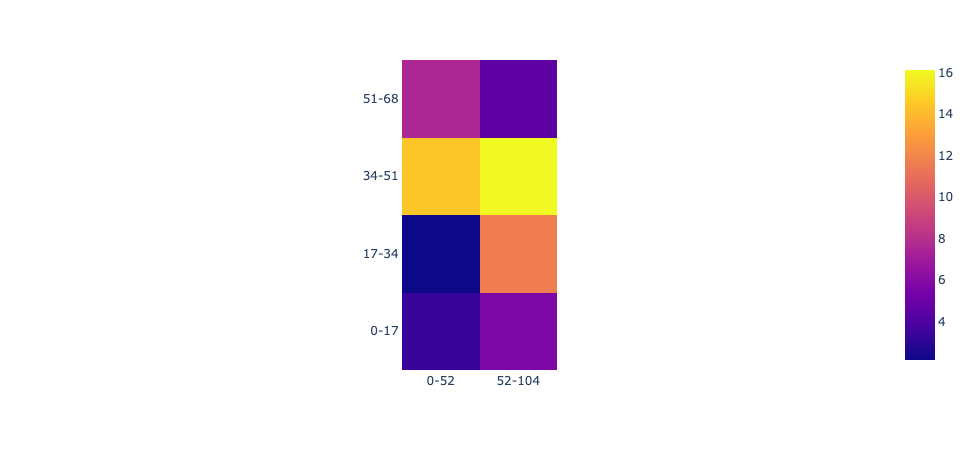

In [51]:
pcolorplotter(rrrl_regionwisevaep)

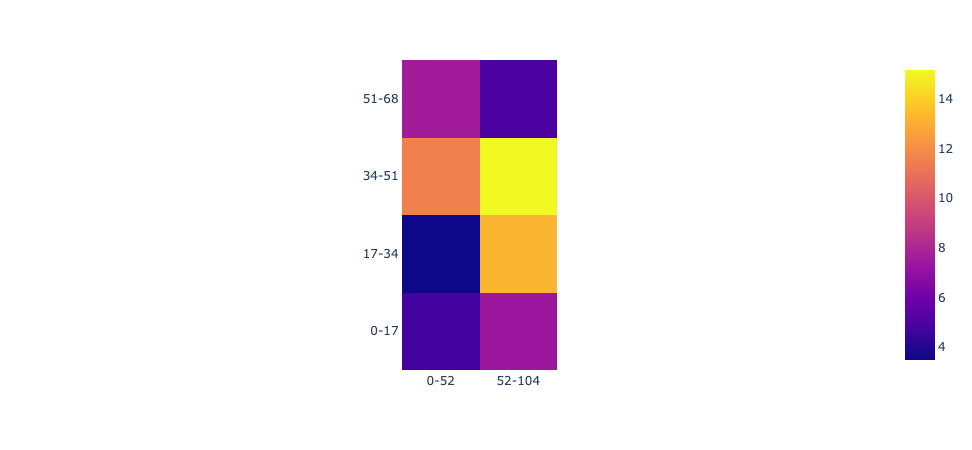

In [52]:
pcolorplotter(rrll_regionwisevaep)

## VAEP patterns for 3 or 5 defender formation for LCB

In [53]:
three_five_clusters = ['rrl','rrr','rll','rrrll','rrrrl','rlr','rrrlr','rrlll']
lcb_lf_clusters = ['rrl','rll','rrrll','rrrlr','rrlll']
lcb_rf_clusters = ['rrr','rrrrl','rlr']
path = '../data/clusters/clusters_prog_vaep/'
lcb_lf_files = [os.path.join(path,f"cluster_prog_vaep_{name}.pkl") for name in lcb_lf_clusters]
lcb_rf_files = [os.path.join(path,f"cluster_prog_vaep_{name}.pkl") for name in lcb_rf_clusters]
lcb_lf = pd.concat((pd.read_pickle(file) for file in lcb_lf_files), axis = 0, ignore_index = True)
lcb_rf = pd.concat((pd.read_pickle(file) for file in lcb_rf_files), axis = 0, ignore_index = True)

In [54]:
lcb_lf_regionwisevaep = regionwisevaep(lcb_lf)
lcb_rf_regionwisevaep = regionwisevaep(lcb_rf)

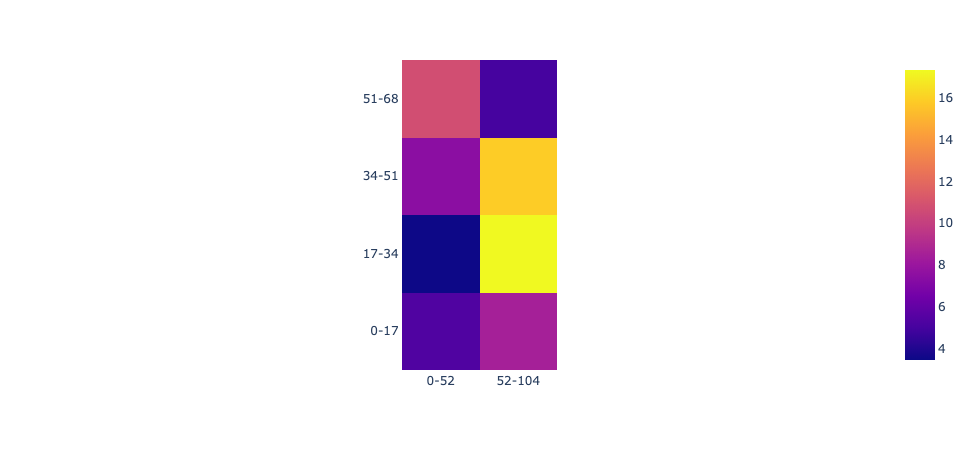

In [55]:
pcolorplotter(lcb_lf_regionwisevaep)

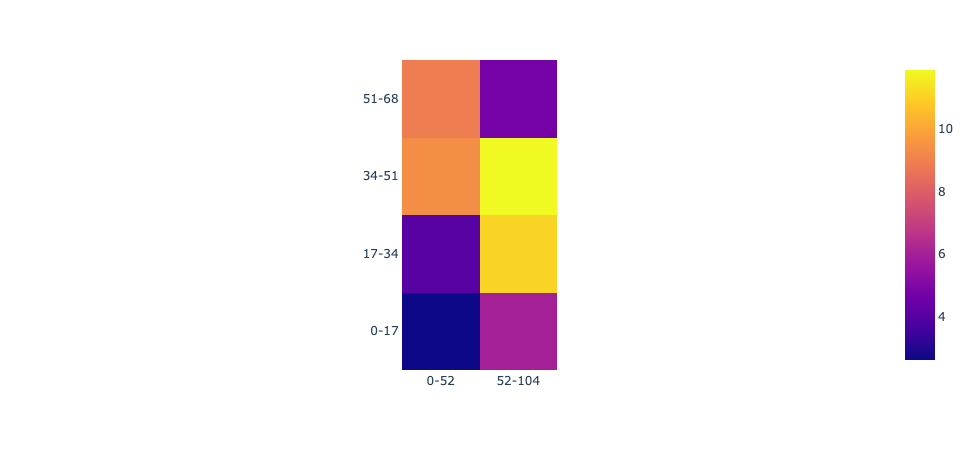

In [56]:
pcolorplotter(lcb_rf_regionwisevaep)